# Modified Regression Model
### Splitting Data by School
I suspect I'll be able to get better results if I model by school.

In [83]:
#import the appropriate tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.figure_factory import create_scatterplotmatrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
%matplotlib inline

In [84]:
#import the data
df = pd.read_csv('test_scores 2.csv')
#list of schools
schools = list(set(df.school))
#list to hold school dataframes
school_dfs=[]
#create one dataframe per school and drop student id col
for sc in schools:
    sc = df[df['school'] == sc]
    sc.drop(['student_id','school_type','school_setting','gender','classroom'],axis=1,inplace=True)
    school_dfs.append(sc)
school_dfs[5].head()

,school,teaching_method,n_student,lunch,pretest,posttest
1682,VHDHF,Experimental,20.0,Qualifies for reduced/free lunch,59.0,72.0
1683,VHDHF,Experimental,20.0,Qualifies for reduced/free lunch,52.0,68.0
1684,VHDHF,Experimental,20.0,Qualifies for reduced/free lunch,55.0,68.0
1685,VHDHF,Experimental,20.0,Qualifies for reduced/free lunch,53.0,69.0
1686,VHDHF,Experimental,20.0,Qualifies for reduced/free lunch,51.0,65.0


> **Comments:** By school, certain types of variables become irrelevant. This may be where some of the collinearity in my first model was coming from. Schools do not have mixed school_setting or school_type. It seems like I'm dealing with two strata of data. School level data and class level data. Because of this, I am going to drop the columns that only have one value by column. The data structure should be more like a 2 table database.

In [85]:
#create dummies for categorical variables
df.drop(['student_id','school_type','school_setting','gender','classroom'],axis=1,inplace=True)
cols_to_fix = ['school','teaching_method','lunch']
dummies = pd.DataFrame()
for item in cols_to_fix:
    new = pd.get_dummies(df[item],prefix=item,drop_first=True)
    dummies = pd.concat([dummies,new],axis=1)

In [86]:
# #drop og columns
df.drop(cols_to_fix,axis=1,inplace=True)
# df = df.drop(['student_id'],axis=1)

In [87]:
#attach leftover og to dummies
df = pd.concat([df,dummies],axis=1)
#fix spaces in lunch column name
df=df.rename(columns={"lunch_Qualifies for reduced/free lunch": "free_lunch"})
df.head()

,n_student,pretest,posttest,school_CCAAW,school_CIMBB,school_CUQAM,school_DNQDD,school_FBUMG,school_GJJHK,school_GOKXL,...,school_UAGPU,school_UKPGS,school_UUUQX,school_VHDHF,school_VKWQH,school_VVTVA,school_ZMNYA,school_ZOWMK,teaching_method_Standard,free_lunch
0,20.0,62.0,72.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,20.0,66.0,79.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,20.0,64.0,76.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,20.0,61.0,77.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,20.0,64.0,76.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [88]:
#create initial model with categoricals and without pretest
outcome = 'posttest'
predictors = df.drop(['posttest','pretest'], axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum
model = ols(formula=formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               posttest   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     420.5
Date:                Thu, 08 Jul 2021   Prob (F-statistic):               0.00
Time:                        22:27:39   Log-Likelihood:                -6744.2
No. Observations:                2133   AIC:                         1.354e+04
Df Residuals:                    2107   BIC:                         1.369e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   72.1482      1.553     46.454      0.000      69.102      75.194
n_student                    0.2591      0.060      4.321      0.000       0.141       0.377
school_CCAAW                 5.0278      1.095      4.591      0.000       2.880       7.175
school_CIMBB                 4.6258      1.127      4.105      0.000       2.416       6.836
school_CUQAM                -8.3934      1.125     -7.462      0.000     -10.599      -6.187
school_DNQDD                -6.2830      1.107     -5.678      0.000      -8.453      -4.113
school_FBUMG                 3.2337      1.307      2.474      0.013       0.670       5.797
school_GJJHK                -5.8203      1.121     -5.194      0.000      -8.018      -3.623
school_GOKXL                -8.2417      1.216     -6.775      0.000     -10.627      -5.856
school_GOOBU               -21.3221      1.136    -18.773      0.000     -23.549     -19.095
school_IDGFP                13.7049      1.086     12.619      0.000      11.575      15.835
school_KFZMY               -18.7164      1.297    -14.434      0.000     -21.259     -16.174
school_KZKKE               -20.6429      1.134    -18.197      0.000     -22.868     -18.418
school_LAYPA                 0.6054      1.183      0.512      0.609      -1.715       2.926
school_OJOBU                -4.4621      1.105     -4.039      0.000      -6.628      -2.296
school_QOQTS                -9.9118      1.055     -9.395      0.000     -11.981      -7.843
school_UAGPU                 0.1498      1.092      0.137      0.891      -1.991       2.291
school_UKPGS                16.6039      1.043     15.925      0.000      14.559      18.649
school_UUUQX                 6.5530      1.122      5.841      0.000       4.353       8.753
school_VHDHF                -4.9289      1.292     -3.815      0.000      -7.462      -2.396
school_VKWQH                -8.6645      1.074     -8.070      0.000     -10.770      -6.559
school_VVTVA               -24.2480      1.232    -19.690      0.000     -26.663     -21.833
school_ZMNYA                 5.7950      1.161      4.992      0.000       3.518       8.072
school_ZOWMK               -19.3290      1.227    -15.747      0.000     -21.736     -16.922
teaching_method_Standard    -5.9896      0.291    -20.572      0.000      -6.561      -5.419
free_lunch                  -3.3684      0.426     -7.899      0.000      -4.205      -2.532
==============================================================================
Omnibus:                        8.246   Durbin-Watson:                   0.637
Prob(Omnibus):                  0.016   Jarque-Bera (JB):                6.667
Skew:                           0.044   Prob(JB):                       0.0357
Kurtosis:                       2.741   Cond. No.                     

In [89]:
name = ['Jarque-Bera','Prob','Skew', 'Kurtosis']
test = sms.jarque_bera(model.resid)
list(zip(name, test))

[('Jarque-Bera', 6.667135850214464),
 ('Prob', 0.03566562550342305),
 ('Skew', 0.044318961924874625),
 ('Kurtosis', 2.7408469213443043)]

> **Comments:** The Jarque-Bera result is about halfway between 0 and 6... need to do research on how best to interperet...the p-value of 0.13 is slightly too high to reject the null hypothesis for normality. The level of skew and kurtosis are in favor of normality.I suspect dropping some of the classroom variables will cause us to see an improvement in model performance.

# Checking for Normality

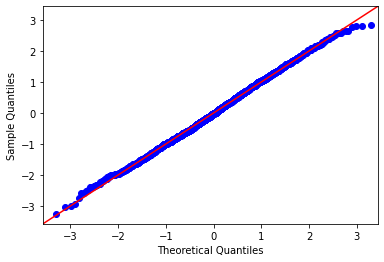

In [90]:
import statsmodels.api as sm
import scipy.stats as stats
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

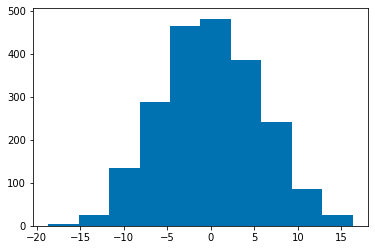

In [91]:
plt.hist(model.resid);

> **Comments:** Overall looks good, would like to drop that outlier. Both ends tip up a bit might try a transformation or two to further normalize that

# Check for Homoscedasticity

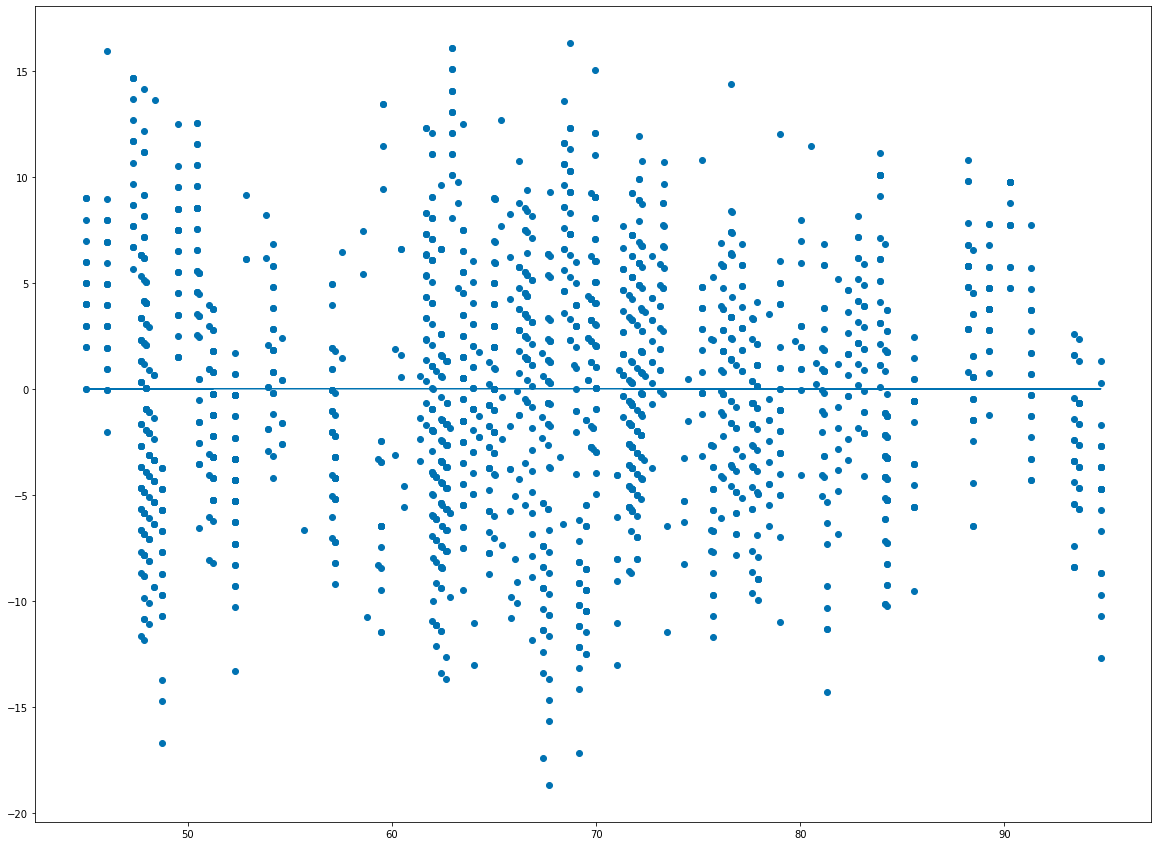

In [92]:
plt.figure(figsize=(20, 15))
plt.scatter(model.predict(df), model.resid)
plt.plot(model.predict(df), [0 for i in range(len(df))]);

> **Comments:** Overall looks good, again with the one outlier. Actually quite happy with the level of homoscedacity.

# Cross Validation

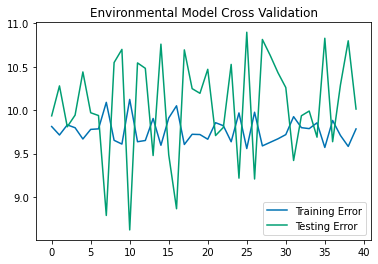

In [156]:
#Run 40 different linear regressions with different train/test splits
y= df[['posttest']]
X= predictors
linreg = LinearRegression()

num = 40
train_err = []
test_err = []
for i in range(num):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    linreg.fit(X_train, y_train)
    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)
    train_err.append(mean_squared_error(y_train, y_hat_train))
    test_err.append(mean_squared_error(y_test, y_hat_test))
plt.plot(list(range(num)), train_err, label='Training Error')
plt.plot(list(range(num)), test_err, label='Testing Error')
plt.title('Environmental Model Cross Validation')
plt.legend();

In [150]:
reg_q = LinearRegression().fit(X, y)
print('RMSE:',np.sqrt(mean_squared_error(y, reg_q.predict(X))))
print('R**2 Score:',r2_score(y, reg_q.predict(X)))

RMSE: 3.1310379810493214
R**2 Score: 0.9498646225247842


### Check the Cross Validation Score

In [99]:
cv5 = cross_val_score(linreg,X,y,cv=5,scoring='neg_mean_squared_error')
print((-cv5)**0.5)
print(np.mean(cv5))

[ 8.83470858 13.51524873 14.93284216 11.5500022  19.55554017]
-199.90510020751145


> **Comments:** Ok, not great. This model, though it has a high R-squared value, is very sensitive to different training/testing data, which makes me think it is overfit.

In [97]:
cross_val_score(linreg,X,y,cv=5,scoring='r2')

array([-0.26558301, -0.13997859,  0.08637737, -0.0542207 , -1.25269336])

> **Comments:** Wow, huge range. Definitely need to address overfitting.

# Model With Pretest

In [101]:
#import the data
df = pd.read_csv('test_scores 2.csv')

In [102]:
df.drop(['student_id','school_type','school_setting','gender','classroom'],axis=1,inplace=True)
cols_to_fix = ['school','teaching_method','lunch']
dummies = pd.DataFrame()
for item in cols_to_fix:
    new = pd.get_dummies(df[item],prefix=item,drop_first=True)
    dummies = pd.concat([dummies,new],axis=1)

In [103]:
df.drop(cols_to_fix,axis=1,inplace=True)

In [104]:
#attach leftover og to dummies
df = pd.concat([df,dummies],axis=1)
#fix spaces in lunch column name
df=df.rename(columns={"lunch_Qualifies for reduced/free lunch": "free_lunch"})
df.head()

,n_student,pretest,posttest,school_CCAAW,school_CIMBB,school_CUQAM,school_DNQDD,school_FBUMG,school_GJJHK,school_GOKXL,...,school_UAGPU,school_UKPGS,school_UUUQX,school_VHDHF,school_VKWQH,school_VVTVA,school_ZMNYA,school_ZOWMK,teaching_method_Standard,free_lunch
0,20.0,62.0,72.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,20.0,66.0,79.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,20.0,64.0,76.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,20.0,61.0,77.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,20.0,64.0,76.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [105]:
#create initial model with categoricals and without pretest
outcome = 'posttest'
predictors = df.drop(['posttest'], axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum
model = ols(formula=formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               posttest   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     1544.
Date:                Thu, 08 Jul 2021   Prob (F-statistic):               0.00
Time:                        23:15:53   Log-Likelihood:                -5454.9
No. Observations:                2133   AIC:                         1.096e+04
Df Residuals:                    2106   BIC:                         1.112e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   26.5690      1.068     24.881      0.000      24.475      28.663
n_student                    0.0095      0.033      0.288      0.773      -0.055       0.074
pretest                      0.8261      0.012     70.347      0.000       0.803       0.849
school_CCAAW                 0.4308      0.602      0.716      0.474      -0.750       1.612
school_CIMBB                 1.1030      0.618      1.785      0.074      -0.109       2.315
school_CUQAM                -1.0563      0.624     -1.694      0.090      -2.279       0.166
school_DNQDD                -1.1531      0.609     -1.893      0.058      -2.348       0.041
school_FBUMG                 0.0523      0.716      0.073      0.942      -1.351       1.456
school_GJJHK                -0.6447      0.617     -1.045      0.296      -1.854       0.565
school_GOKXL                -1.5971      0.672     -2.378      0.017      -2.914      -0.280
school_GOOBU                -3.2726      0.672     -4.872      0.000      -4.590      -1.955
school_IDGFP                 1.9440      0.617      3.153      0.002       0.735       3.153
school_KFZMY                -3.5304      0.741     -4.766      0.000      -4.983      -2.078
school_KZKKE                -3.1211      0.668     -4.671      0.000      -4.431      -1.811
school_LAYPA                -0.2538      0.647     -0.392      0.695      -1.522       1.015
school_OJOBU                -0.5390      0.606     -0.889      0.374      -1.728       0.650
school_QOQTS                -1.6687      0.588     -2.836      0.005      -2.823      -0.515
school_UAGPU                -0.3963      0.597     -0.664      0.507      -1.566       0.774
school_UKPGS                 2.7856      0.603      4.622      0.000       1.604       3.968
school_UUUQX                 0.6203      0.619      1.002      0.316      -0.593       1.834
school_VHDHF                -1.0763      0.708     -1.520      0.129      -2.465       0.312
school_VKWQH                -1.3372      0.596     -2.244      0.025      -2.506      -0.169
school_VVTVA                -4.0763      0.732     -5.572      0.000      -5.511      -2.642
school_ZMNYA                 0.5183      0.639      0.811      0.417      -0.735       1.771
school_ZOWMK                -3.3562      0.708     -4.739      0.000      -4.745      -1.967
teaching_method_Standard    -6.0371      0.159    -37.942      0.000      -6.349      -5.725
free_lunch                  -0.4857      0.237     -2.053      0.040      -0.950      -0.022
==============================================================================
Omnibus:                        4.339   Durbin-Watson:                   1.833
Prob(Omnibus):                  0.114   Jarque-Bera (JB):                4.924
Skew:                           0.012   Prob(JB):       

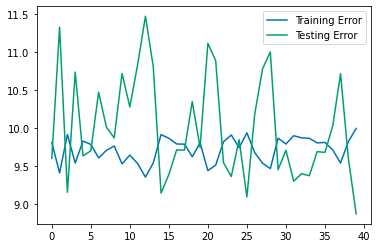

In [106]:
#Run 40 different linear regressions with different train/test splits
y= df[['posttest']]
X= predictors
linreg = LinearRegression()

num = 40
train_err = []
test_err = []
for i in range(num):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    linreg.fit(X_train, y_train)
    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)
    train_err.append(mean_squared_error(y_train, y_hat_train))
    test_err.append(mean_squared_error(y_test, y_hat_test))
plt.plot(list(range(num)), train_err, label='Training Error')
plt.plot(list(range(num)), test_err, label='Testing Error')
plt.legend();

In [107]:
reg_q = LinearRegression().fit(X, y)
print('RMSE:',np.sqrt(mean_squared_error(y, reg_q.predict(X))))
print('R**2 Score:',r2_score(y, reg_q.predict(X)))

RMSE: 3.12193179057927
R**2 Score: 0.9501558220594473


In [108]:
cv5 = cross_val_score(linreg,X,y,cv=5,scoring='neg_mean_squared_error')
print((-cv5)**0.5)
print(np.mean(cv5))

[3.37870845 3.59620662 3.87388062 3.49306372 4.86502474]
-15.045056763980076


### Dropping some features and trying again

In [109]:
#import the data
df = pd.read_csv('test_scores 2.csv')

In [110]:
df.drop(['student_id','school_type','school_setting','gender','classroom'],axis=1,inplace=True)
cols_to_fix = ['school','teaching_method','lunch']
dummies = pd.DataFrame()
for item in cols_to_fix:
    new = pd.get_dummies(df[item],prefix=item,drop_first=True)
    dummies = pd.concat([dummies,new],axis=1)

In [111]:
df.drop(cols_to_fix,axis=1,inplace=True)

In [112]:
#attach leftover og to dummies
df = pd.concat([df,dummies],axis=1)
#fix spaces in lunch column name
df=df.rename(columns={"lunch_Qualifies for reduced/free lunch": "free_lunch"})
df.head()

,n_student,pretest,posttest,school_CCAAW,school_CIMBB,school_CUQAM,school_DNQDD,school_FBUMG,school_GJJHK,school_GOKXL,...,school_UAGPU,school_UKPGS,school_UUUQX,school_VHDHF,school_VKWQH,school_VVTVA,school_ZMNYA,school_ZOWMK,teaching_method_Standard,free_lunch
0,20.0,62.0,72.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,20.0,66.0,79.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,20.0,64.0,76.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,20.0,61.0,77.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,20.0,64.0,76.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [138]:
#create initial model with categoricals and without pretest
outcome = 'posttest'
predictors = df.drop(['posttest','n_student','school_FBUMG','school_CCAAW','school_LAYPA','school_OJOBU',
                      'school_UAGPU','school_GJJHK','school_ZMNYA','school_UUUQX'], axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum
model = ols(formula=formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               posttest   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     2357.
Date:                Thu, 08 Jul 2021   Prob (F-statistic):               0.00
Time:                        23:28:36   Log-Likelihood:                -5461.1
No. Observations:                2133   AIC:                         1.096e+04
Df Residuals:                    2115   BIC:                         1.106e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   25.8729      0.706     36.662      0.000      24.489      27.257
pretest                      0.8412      0.011     78.001      0.000       0.820       0.862
school_CIMBB                 1.0829      0.389      2.780      0.005       0.319       1.847
school_CUQAM                -0.8238      0.340     -2.424      0.015      -1.490      -0.157
school_DNQDD                -0.9407      0.322     -2.920      0.004      -1.572      -0.309
school_GOKXL                -1.3901      0.437     -3.184      0.001      -2.246      -0.534
school_GOOBU                -2.7630      0.374     -7.382      0.000      -3.497      -2.029
school_IDGFP                 1.7554      0.374      4.695      0.000       1.022       2.489
school_KFZMY                -3.1255      0.500     -6.249      0.000      -4.106      -2.145
school_KZKKE                -2.6161      0.418     -6.256      0.000      -3.436      -1.796
school_QOQTS                -1.4518      0.307     -4.727      0.000      -2.054      -0.849
school_UKPGS                 2.5649      0.350      7.336      0.000       1.879       3.251
school_VHDHF                -0.9320      0.479     -1.947      0.052      -1.871       0.007
school_VKWQH                -1.1636      0.357     -3.263      0.001      -1.863      -0.464
school_VVTVA                -3.5509      0.422     -8.417      0.000      -4.378      -2.724
school_ZOWMK                -2.8821      0.383     -7.515      0.000      -3.634      -2.130
teaching_method_Standard    -6.1476      0.150    -41.099      0.000      -6.441      -5.854
free_lunch                  -0.5332      0.208     -2.562      0.010      -0.941      -0.125
==============================================================================
Omnibus:                        4.213   Durbin-Watson:                   1.846
Prob(Omnibus):                  0.122   Jarque-Bera (JB):                4.712
Skew:                           0.024   Prob(JB):                       0.0948
Kurtosis:                       3.225   Cond. No.                         810.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

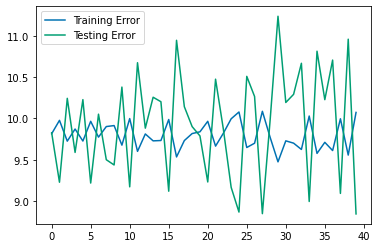

In [142]:
#Run 40 different linear regressions with different train/test splits
y= df[['posttest']]
X= predictors
linreg = LinearRegression()

num = 40
train_err = []
test_err = []
for i in range(num):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    linreg.fit(X_train, y_train)
    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)
    train_err.append(mean_squared_error(y_train, y_hat_train))
    test_err.append(mean_squared_error(y_test, y_hat_test))
plt.plot(list(range(num)), train_err, label='Training Error')
plt.plot(list(range(num)), test_err, label='Testing Error')
plt.legend();

In [143]:
reg_q = LinearRegression().fit(X, y)
print('RMSE:',np.sqrt(mean_squared_error(y, reg_q.predict(X))))
print('R**2 Score:',r2_score(y, reg_q.predict(X)))

RMSE: 3.1310379810493214
R**2 Score: 0.9498646225247842


In [144]:
cv5 = cross_val_score(linreg,X,y,cv=5,scoring='neg_mean_squared_error')
print((-cv5)**0.5)
print(np.mean(cv5))

[3.27560228 3.64546966 3.62719446 3.45949416 4.16674302]
-13.301081239314367


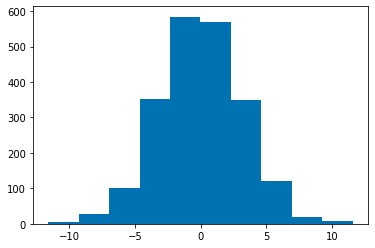

In [146]:
plt.hist(model.resid);